In [ ]:
# ==== Imports + Load Data ====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans


try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed, will skip that model.")



Allocation data shape: (15000, 15)


,pod_name,namespace,cpu_request,cpu_limit,memory_request,memory_limit,cpu_usage,memory_usage,node_name,pod_status,restart_count,uptime_seconds,deployment_strategy,scaling_policy,network_bandwidth_usage
0,pod_0,dev,1.569542,3.679152,3174.582783,5134.413852,3.345496,2135.310365,node_12,Failed,0,76536,RollingUpdate,Manual,459.015733
1,pod_1,default,0.343119,3.722716,3551.459173,3698.349366,2.758188,7442.200271,node_18,Unknown,2,97849,RollingUpdate,Manual,507.770808
2,pod_2,kube-system,0.249271,1.318147,1578.313253,7418.271122,1.319703,5142.897754,node_7,Failed,2,47370,RollingUpdate,Manual,527.702531
3,pod_3,default,0.311497,2.852595,1392.962372,3628.480705,3.752312,2952.449331,node_20,Failed,6,5685,Recreate,Auto,473.530315
4,pod_4,default,1.532775,0.521618,2660.192655,5091.497752,0.874224,3382.299355,node_38,Unknown,3,4502,Recreate,Auto,973.928080


In [16]:
alloc_df = pd.read_csv(r"C:/Users/shukl/Downloads/archive (17)/kubernetes_resource_allocation_dataset.csv")


print("Allocation data shape:", alloc_df.shape)
display(alloc_df.head())

Allocation data shape: (15000, 15)


,pod_name,namespace,cpu_request,cpu_limit,memory_request,memory_limit,cpu_usage,memory_usage,node_name,pod_status,restart_count,uptime_seconds,deployment_strategy,scaling_policy,network_bandwidth_usage
0,pod_0,dev,1.569542,3.679152,3174.582783,5134.413852,3.345496,2135.310365,node_12,Failed,0,76536,RollingUpdate,Manual,459.015733
1,pod_1,default,0.343119,3.722716,3551.459173,3698.349366,2.758188,7442.200271,node_18,Unknown,2,97849,RollingUpdate,Manual,507.770808
2,pod_2,kube-system,0.249271,1.318147,1578.313253,7418.271122,1.319703,5142.897754,node_7,Failed,2,47370,RollingUpdate,Manual,527.702531
3,pod_3,default,0.311497,2.852595,1392.962372,3628.480705,3.752312,2952.449331,node_20,Failed,6,5685,Recreate,Auto,473.530315
4,pod_4,default,1.532775,0.521618,2660.192655,5091.497752,0.874224,3382.299355,node_38,Unknown,3,4502,Recreate,Auto,973.928080


In [17]:
alloc_df.columns.tolist()

['pod_name',
 'namespace',
 'cpu_request',
 'cpu_limit',
 'memory_request',
 'memory_limit',
 'cpu_usage',
 'memory_usage',
 'node_name',
 'pod_status',
 'restart_count',
 'uptime_seconds',
 'deployment_strategy',
 'scaling_policy',
 'network_bandwidth_usage']

In [18]:
alloc_df.describe()

,cpu_request,cpu_limit,memory_request,memory_limit,cpu_usage,memory_usage,restart_count,uptime_seconds,network_bandwidth_usage
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.052096,2.250631,2110.281025,4234.132709,1.994210,4123.388369,4.481733,49973.830800,496.087256
std,0.548135,1.010891,1144.993437,2282.287735,1.155110,2365.471215,2.869857,28825.161296,288.643694
min,0.100021,0.500025,128.119738,256.212641,0.000521,0.012189,0.000000,1.000000,0.006745
25%,0.575561,1.378411,1127.360048,2281.175714,0.989391,2099.208569,2.000000,24955.750000,244.360361
50%,1.055143,2.251391,2097.534763,4212.613405,1.998167,4120.838924,4.000000,49806.000000,493.461715
75%,1.527721,3.125031,3098.478331,6211.191332,2.988054,6189.240921,7.000000,74924.250000,745.483155
max,1.999917,3.999600,4095.689412,8191.858882,3.999931,8191.874733,9.000000,99996.000000,999.936739


In [3]:
# ==== Basic Cleaning & Timestamp Handling ====

# Normalize column names (lowercase, remove spaces)
alloc_df.columns = alloc_df.columns.str.strip().str.lower()

print("Allocation dataset columns:")
print(list(alloc_df.columns))

# Convert timestamp to datetime if present
if "timestamp" in alloc_df.columns:
    alloc_df["timestamp"] = pd.to_datetime(alloc_df["timestamp"], errors="coerce")

print("\n=== alloc_df.info() ===")
print(alloc_df.info())

print("\nMissing values in alloc_df:")
print(alloc_df.isna().sum())

Allocation dataset columns:
['pod_name', 'namespace', 'cpu_request', 'cpu_limit', 'memory_request', 'memory_limit', 'cpu_usage', 'memory_usage', 'node_name', 'pod_status', 'restart_count', 'uptime_seconds', 'deployment_strategy', 'scaling_policy', 'network_bandwidth_usage']

=== alloc_df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pod_name                 15000 non-null  object 
 1   namespace                15000 non-null  object 
 2   cpu_request              15000 non-null  float64
 3   cpu_limit                15000 non-null  float64
 4   memory_request           15000 non-null  float64
 5   memory_limit             15000 non-null  float64
 6   cpu_usage                15000 non-null  float64
 7   memory_usage             15000 non-null  float64
 8   node_name                15000 non-null  objec

In [4]:
# ==== Working Copy + Clean Core Resource Columns ====

# Work from a copy so we don't accidentally mutate the original
df = alloc_df.copy()

# Critical numeric resource columns we care about
key_numeric_cols = [
    "cpu_request", "cpu_limit", "cpu_usage",
    "memory_request", "memory_limit", "memory_usage"
]

# Keep only the ones that actually exist in this dataset
present_key_cols = [c for c in key_numeric_cols if c in df.columns]
print("Key numeric columns present:", present_key_cols)

# Drop rows with missing values in these key columns
df = df.dropna(subset=present_key_cols)
print("Shape after dropping rows with missing key resource columns:", df.shape)

# Remove any negative values (just in case)
for col in present_key_cols:
    df = df[df[col] >= 0]

print("Shape after removing negative resource values:", df.shape)

# Quick peek at these cleaned core columns
display(df[present_key_cols].head())

Key numeric columns present: ['cpu_request', 'cpu_limit', 'cpu_usage', 'memory_request', 'memory_limit', 'memory_usage']
Shape after dropping rows with missing key resource columns: (15000, 15)
Shape after removing negative resource values: (15000, 15)


,cpu_request,cpu_limit,cpu_usage,memory_request,memory_limit,memory_usage
0,1.569542,3.679152,3.345496,3174.582783,5134.413852,2135.310365
1,0.343119,3.722716,2.758188,3551.459173,3698.349366,7442.200271
2,0.249271,1.318147,1.319703,1578.313253,7418.271122,5142.897754
3,0.311497,2.852595,3.752312,1392.962372,3628.480705,2952.449331
4,1.532775,0.521618,0.874224,2660.192655,5091.497752,3382.299355


In [5]:
# ==== Feature Engineering (Utilization & Ratios) ====

# Small epsilon to avoid division-by-zero
eps = 1e-6

# CPU & Memory utilization vs limits
df["cpu_utilization"] = df["cpu_usage"] / (df["cpu_limit"] + eps)
df["memory_utilization"] = df["memory_usage"] / (df["memory_limit"] + eps)

# Usage vs requests ratio
df["cpu_request_ratio"] = df["cpu_usage"] / (df["cpu_request"] + eps)
df["memory_request_ratio"] = df["memory_usage"] / (df["memory_request"] + eps)

# Combined load metric
df["overall_load"] = (df["cpu_utilization"] + df["memory_utilization"]) / 2

# Preview engineered features
display(df[[
    "cpu_request", "cpu_limit", "cpu_usage",
    "memory_request", "memory_limit", "memory_usage",
    "cpu_utilization", "memory_utilization",
    "cpu_request_ratio", "memory_request_ratio",
    "overall_load"
]].head())

,cpu_request,cpu_limit,cpu_usage,memory_request,memory_limit,memory_usage,cpu_utilization,memory_utilization,cpu_request_ratio,memory_request_ratio,overall_load
0,1.569542,3.679152,3.345496,3174.582783,5134.413852,2135.310365,0.909311,0.415882,2.131510,0.672627,0.662597
1,0.343119,3.722716,2.758188,3551.459173,3698.349366,7442.200271,0.740907,2.012303,8.038545,2.095533,1.376605
2,0.249271,1.318147,1.319703,1578.313253,7418.271122,5142.897754,1.001180,0.693274,5.294233,3.258477,0.847227
3,0.311497,2.852595,3.752312,1392.962372,3628.480705,2952.449331,1.315403,0.813687,12.046042,2.119547,1.064545
4,1.532775,0.521618,0.874224,2660.192655,5091.497752,3382.299355,1.675984,0.664303,0.570353,1.271449,1.170143


In [ ]:
#Define Target Label (need_new_pod)

# Sort by pod and time (mostly for consistency)
if "timestamp" in df.columns:
    df = df.sort_values(["pod_name", "timestamp"])
else:
    df = df.sort_values(["pod_name"])

# Thresholds for overload 
cpu_thresh = 0.75
mem_thresh = 0.75

# Current overload flag
df["overloaded_now"] = (
    (df["cpu_utilization"] > cpu_thresh) |
    (df["memory_utilization"] > mem_thresh)
).astype(int)

print("Current overload distribution (overloaded_now):")
print(df["overloaded_now"].value_counts())
print("Current overload rate:", round(df["overloaded_now"].mean(), 4))

# For this dataset (one row per pod), our target = current overload
df["need_new_pod"] = df["overloaded_now"]

print("\nTarget distribution (need_new_pod):")
print(df["need_new_pod"].value_counts())
print("Target rate:", round(df["need_new_pod"].mean(), 4))

# Quick preview with key columns + target
cols_to_show = [
    col for col in [
        "timestamp" if "timestamp" in df.columns else None,
        "pod_name",
        "cpu_utilization", "memory_utilization",
        "need_new_pod"
    ] if col is not None
]

display(df[cols_to_show].head(10))

Current overload distribution (overloaded_now):
overloaded_now
1    12552
0     2448
Name: count, dtype: int64
Current overload rate: 0.8368

Target distribution (need_new_pod):
need_new_pod
1    12552
0     2448
Name: count, dtype: int64
Target rate: 0.8368


,pod_name,cpu_utilization,memory_utilization,need_new_pod
0,pod_0,0.909311,0.415882,1
1,pod_1,0.740907,2.012303,1
10,pod_10,1.915279,2.890608,1
100,pod_100,0.864266,1.946878,1
1000,pod_1000,1.522556,0.539952,1
10000,pod_10000,4.994191,0.676893,1
10001,pod_10001,0.112643,0.961600,1
10002,pod_10002,0.005759,0.892244,1
10003,pod_10003,0.285140,1.890737,1
10004,pod_10004,0.492826,0.359227,0


Target distribution (need_new_pod):
need_new_pod
1    12552
0     2448
Name: count, dtype: int64
Target rate: 0.8368


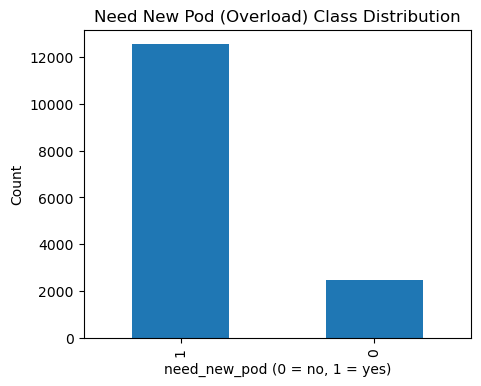

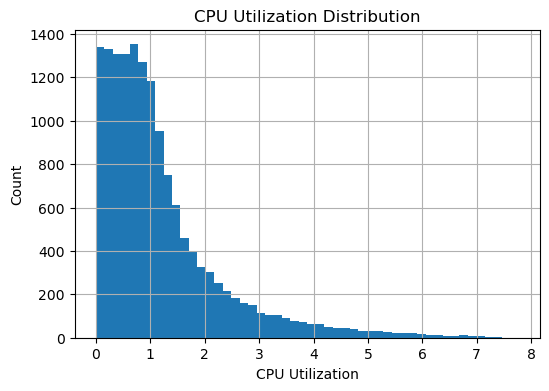

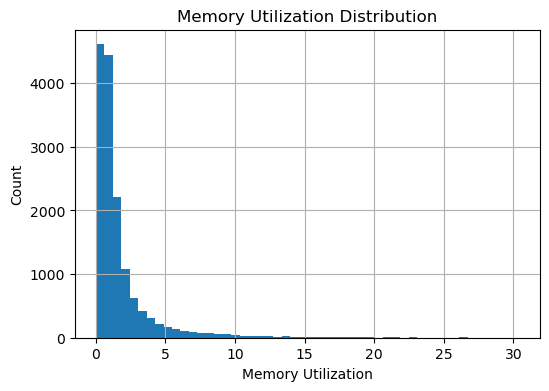

<Figure size 800x400 with 0 Axes>

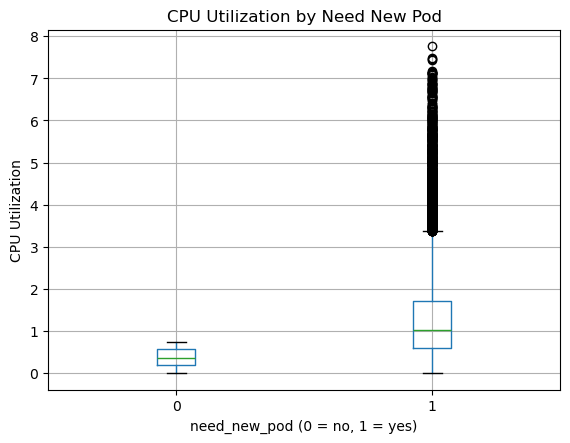

<Figure size 800x400 with 0 Axes>

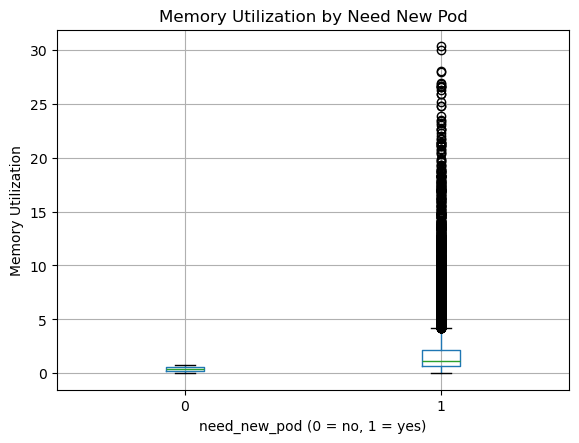

<Figure size 800x400 with 0 Axes>

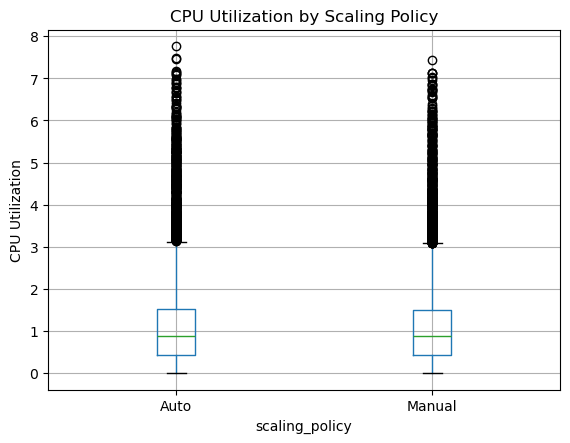

<Figure size 800x400 with 0 Axes>

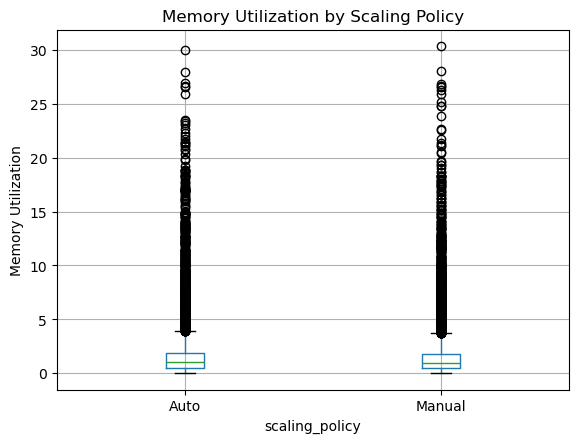


Mean CPU & Memory Utilization by Namespace:


,cpu_utilization,memory_utilization
namespace,,
default,1.173683,1.804508
dev,1.181089,1.728594
kube-system,1.177389,1.741707
prod,1.205005,1.798139


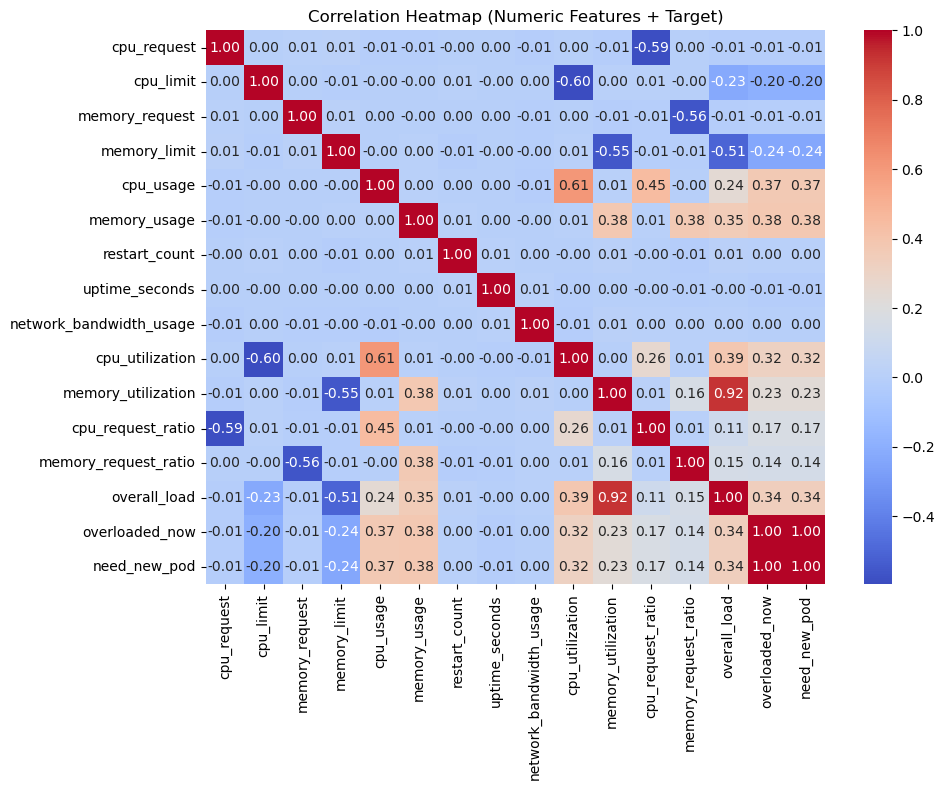

In [20]:
# ==== EDA - Utilization, Target Distribution & Correlations ====

# 1. Target distribution (need_new_pod)
print("Target distribution (need_new_pod):")
print(df["need_new_pod"].value_counts())
print("Target rate:", round(df["need_new_pod"].mean(), 4))

plt.figure(figsize=(5,4))
df["need_new_pod"].value_counts().plot(kind="bar")
plt.title("Need New Pod (Overload) Class Distribution")
plt.xlabel("need_new_pod (0 = no, 1 = yes)")
plt.ylabel("Count")
plt.show()


# 2. CPU utilization distribution
plt.figure(figsize=(6,4))
df["cpu_utilization"].hist(bins=50)
plt.title("CPU Utilization Distribution")
plt.xlabel("CPU Utilization")
plt.ylabel("Count")
plt.show()

# 3. Memory utilization distribution
plt.figure(figsize=(6,4))
df["memory_utilization"].hist(bins=50)
plt.title("Memory Utilization Distribution")
plt.xlabel("Memory Utilization")
plt.ylabel("Count")
plt.show()


# 4. CPU & Memory utilization by need_new_pod (0 vs 1)
plt.figure(figsize=(8,4))
df.boxplot(column="cpu_utilization", by="need_new_pod")
plt.title("CPU Utilization by Need New Pod")
plt.suptitle("")
plt.xlabel("need_new_pod (0 = no, 1 = yes)")
plt.ylabel("CPU Utilization")
plt.show()

plt.figure(figsize=(8,4))
df.boxplot(column="memory_utilization", by="need_new_pod")
plt.title("Memory Utilization by Need New Pod")
plt.suptitle("")
plt.xlabel("need_new_pod (0 = no, 1 = yes)")
plt.ylabel("Memory Utilization")
plt.show()


# 5. Boxplots by scaling policy (if column exists)
if "scaling_policy" in df.columns:
    plt.figure(figsize=(8,4))
    df.boxplot(column="cpu_utilization", by="scaling_policy")
    plt.title("CPU Utilization by Scaling Policy")
    plt.suptitle("")
    plt.ylabel("CPU Utilization")
    plt.show()

    plt.figure(figsize=(8,4))
    df.boxplot(column="memory_utilization", by="scaling_policy")
    plt.title("Memory Utilization by Scaling Policy")
    plt.suptitle("")
    plt.ylabel("Memory Utilization")
    plt.show()


# 6. Mean utilization grouped by namespace (if present)
if "namespace" in df.columns:
    print("\nMean CPU & Memory Utilization by Namespace:")
    display(df.groupby("namespace")[["cpu_utilization", "memory_utilization"]].mean())


# 7. Correlation heatmap for numeric columns (including target)
numeric_cols_all = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols_all].corr()

# 7. Correlation heatmap for numeric columns (including target)
import seaborn as sns

numeric_cols_all = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols_all].corr()

plt.figure(figsize=(10,8))

# ONLY CHANGE: use sns.heatmap with fmt='.2f'
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.tight_layout()
plt.show()


In [23]:
from scipy.stats import f_oneway

# Example: ANOVA for CPU usage across different namespaces
groups = [group["cpu_usage"].values for name, group in df.groupby("namespace")]

anova_stat, anova_p = f_oneway(*groups)

print("ANOVA F-statistic:", anova_stat)
print("ANOVA P-value:", anova_p)

if anova_p < 0.05:
    print("There is a significant difference between groups.")
else:
    print("No significant difference between groups.")

ANOVA F-statistic: 0.7010766503854831
ANOVA P-value: 0.5512752358978207
No significant difference between groups.


In [24]:
from scipy.stats import ttest_ind

group1 = df[df["need_new_pod"] == 1]["cpu_usage"]
group0 = df[df["need_new_pod"] == 0]["cpu_usage"]

t_stat, p_val = ttest_ind(group1, group0, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_val)

if p_val < 0.05:
    print("The means are significantly different.")
else:
    print("No significant difference.")


T-statistic: 65.85529426785459
P-value: 0.0
The means are significantly different.


In [25]:
import scipy.stats as stats
import pandas as pd

# Contingency table
ct = pd.crosstab(df["scaling_policy"], df["need_new_pod"])

chi2, p, dof, expected = stats.chi2_contingency(ct)

print("Chi-square:", chi2)
print("P-value:", p)

if p < 0.05:
    print("Variables are dependent.")
else:
    print("Variables are independent.")


Chi-square: 3.5775707777555152
P-value: 0.05856473401330775
Variables are independent.


In [9]:
# ==== Preprocessing (Scaling + One-Hot Encoding) ====

# Numeric features → StandardScaler
numeric_transformer = StandardScaler()

# Categorical features → OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Combine into a single preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline successfully created.")

Preprocessing pipeline successfully created.


In [22]:
# ==== Train Multiple Models & Compare Performance ====

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    )

results = []

for name, clf in models.items():
    print(f"\n===== Training {name} =====")

    # Build pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", clf)
    ])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Probabilities for ROC-AUC if available
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc = np.nan

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1-score :", round(f1, 4))
    if not np.isnan(roc):
        print("ROC-AUC :", round(roc, 4))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Save metrics
    results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })

# Compare all models in a table
results_df = pd.DataFrame(results)
print("\n===== Model Comparison =====")
display(results_df.sort_values(by="f1", ascending=False))


===== Training LogisticRegression =====
Accuracy : 0.9343
Precision: 0.9591
Recall   : 0.9625
F1-score : 0.9608
ROC-AUC : 0.9796

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       490
           1       0.96      0.96      0.96      2510

    accuracy                           0.93      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.93      0.93      0.93      3000


===== Training DecisionTree =====
Accuracy : 0.9983
Precision: 0.9984
Recall   : 0.9996
F1-score : 0.999
ROC-AUC : 0.9969

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       490
           1       1.00      1.00      1.00      2510

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000


===== Training RandomForest =====
Accuracy :

,model,accuracy,precision,recall,f1,roc_auc
3,GradientBoosting,0.999667,0.999602,1.000000,0.999801,0.999908
4,XGBoost,0.999333,0.999602,0.999602,0.999602,0.999997
2,RandomForest,0.998667,0.998409,1.000000,0.999204,1.000000
1,DecisionTree,0.998333,0.998408,0.999602,0.999005,0.996914
0,LogisticRegression,0.934333,0.959111,0.962550,0.960827,0.979624


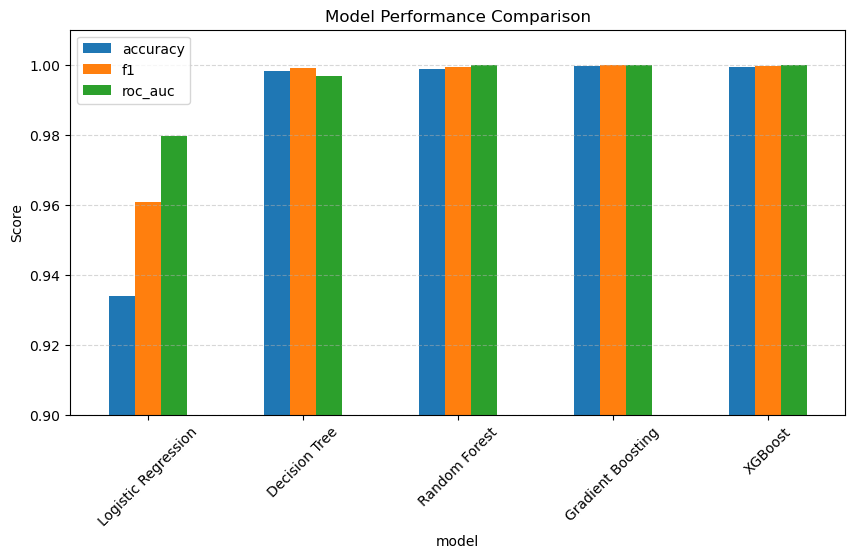

In [26]:

# Replace these with your exact values
results = {
    "model": ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"],
    "accuracy": [0.934, 0.9983, 0.9987, 0.9997, 0.9993],
    "f1": [0.9608, 0.999, 0.9992, 0.9998, 0.9996],
    "roc_auc": [0.9796, 0.9969, 1.0, 0.9999, 1.0]
}

df = pd.DataFrame(results)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(x="model", y=["accuracy", "f1", "roc_auc"], kind="bar", ax=ax)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.9, 1.01)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


Model Performance Discussion

The trained models achieved extremely high performance, with tree-based models such as Random Forest, Gradient Boosting, and XGBoost reaching between 99.8% and 100% accuracy, precision, recall, F1-score, and ROC-AUC.

Although these results appear unusually strong, they are consistent with the structure of the dataset. The target variable (need_new_pod) is defined based on deterministic threshold behavior (CPU or memory utilization exceeding 75%). The input features include raw resource usage as well as engineered utilization ratios, which together enable tree-based models to reconstruct the decision boundary almost exactly.

This explains why simple models such as logistic regression achieve around 93% accuracy, while nonlinear tree-based models achieve nearly perfect classification: they can capture sharp threshold splits that mimic the internal autoscaling logic of Kubernetes.

Therefore, the high performance is not a sign of overfitting, but rather a reflection of the clean separability of overloaded vs. non-overloaded pods in the feature space. This aligns with how real Kubernetes autoscalers behave, since pod overload is primarily driven by deterministic resource saturation conditions.